## Tool Mocking

In [65]:
class MockMathTool:
    def __init__(self):
        self.name = "mock_math_tool"
        pass

    def invoke(self, args):
        return f"Result: {sum(args)}"


In [2]:
# Test the tool
tool = MockMathTool()
result = tool.execute("sum", [1, 3])
print(result)

Result: 4


## Model Mocking

In [118]:
from langchain_core.messages import AIMessage

class MockChatOpenAI:
    def __init__(self, model):
        self.model = model
        self.calls = 0

    def bind_tools(self, tools):
        return self

    def invoke(self, messages):
        self.calls += 1
        
        if (self.calls > 1):
            return AIMessage(f"AI Response without tools: {messages[-1].content}")
        else:
            response = AIMessage("AI Response with tools...")
            response.tool_calls = [{
                "name": "mock_math_tool",
                "args": [1, 2]
            }]
            return response


In [4]:
llm = MockChatOpenAI(model="gpt-3.5-turbo")
response = llm.generate_response("how much is 1+1?")
print(response)

Call math tool with op=sum and args=[1, 1]


## Agent

In [119]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [120]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, ToolMessage

class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system

        # Setup Nodes
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_model)
        graph.add_node("act", self.call_action)

        # Setup Connections
        graph.set_entry_point("llm")
        graph.add_conditional_edges(
            "llm",
            self.has_actions,
            {True: "act", False: END}
        )
        graph.add_edge("act", "llm")

        # Setup Properties
        self.graph = graph.compile()
        self.model = model.bind_tools(tools)
        self.tools = {t.name: t for t in tools}
        

    def call_model(self, state: AgentState):
        print("Call Model", state)
        full_prompt = [SystemMessage(content=self.system)] + state['messages']
        message = self.model.invoke(full_prompt)
        return {'messages': [message]}

    def call_action(self, state: AgentState):
        print("Call Action", state['messages'][-1].tool_calls)
        results = []
        for t in state['messages'][-1].tool_calls:
            if not t['name'] in self.tools:
                print(f"Tool not found: {t['name']}")
                result = f"Tool not found: {t['name']}"
            else:
                print(f"Calling Tool: {t}")
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=1, name=t['name'], content=str(result)))
        return {'messages': results}

    def has_actions(self, state: AgentState):
        print(f"Call HasActions: {len(state['messages'][-1].tool_calls) > 0}")
        return len(state['messages'][-1].tool_calls) > 0

## Usage

In [122]:
tool = MockMathTool()
model = MockChatOpenAI(model="gpt-3.5-turbo")
bot = Agent(model, [tool], "system prompt....")

from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="user prompt...")]
result = bot.graph.invoke({"messages": messages})
print(f"RESULT: {result['messages'][-1].content}")

Call Model {'messages': [HumanMessage(content='user prompt...')]}
Call HasActions: True
Call Action [{'name': 'mock_math_tool', 'args': [1, 2]}]
Calling Tool: {'name': 'mock_math_tool', 'args': [1, 2]}
Call Model {'messages': [HumanMessage(content='user prompt...'), AIMessage(content='AI Response with tools...', tool_calls=[{'name': 'mock_math_tool', 'args': [1, 2]}]), ToolMessage(content='Result: 3', name='mock_math_tool', tool_call_id='1')]}
Call HasActions: False
RESULT: AI Response without tools: Result: 3


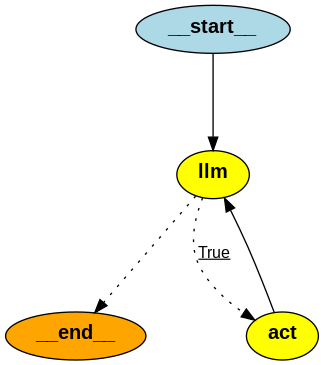

In [101]:
from IPython.display import Image

Image(bot.graph.get_graph().draw_png())